In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
%matplotlib inline


In [38]:
def create_benchmark(function):
    #  2 functions of many local minimas
    resolution = 1000

    if function == "Ackley":
        a = (-32.768, 32.768)
        x, y = np.meshgrid(np.linspace(a[0], a[1], resolution), np.linspace(a[0], a[1], resolution))
        def fx(x, y): return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 20
        z = fx(x, y)
        return z, x, y, a, fx

    if function == "Rastgrin":
        a = (-5.12, 5.12)
        x, y = np.meshgrid(np.linspace(a[0], a[1], resolution), np.linspace(a[0], a[1], resolution))
        def fx(x, y): return (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y)) + 20
        z = fx(x, y)
        return z, x, y, a, fx

    if function == "Sphere":
        a = (-100, 100)
        x, y = np.meshgrid(np.linspace(a[0], a[1], resolution), np.linspace(a[0], a[1], resolution))
        def fx(x, y): return (4/3)*math.pi*x**3
        z = fx(x, y)
        return z, x, y, a, fx

    if function == "Rosenbrock":
        a = (-5, 10)
        x, y = np.meshgrid(np.linspace(a[0], a[1], resolution), np.linspace(a[0], a[1], resolution))
        def fx(x, y): return (1-x)**2 + 100*(y-x**2)**2
        z = fx(x, y)
        return z, x, y, a, fx

    if function == "Booth":
        a = (-10, 10)
        x, y = np.meshgrid(np.linspace(a[0], a[1], resolution), np.linspace(a[0], a[1], resolution))
        def fx(x, y): return (x+2*y-7)**2 + (2*x+y-5)**2
        z = fx(x, y)
        return z, x, y, a, fx

    if function == "Easom":
        a = (-100, 100)
        x, y = np.meshgrid(np.linspace(a[0], a[1], resolution), np.linspace(a[0], a[1], resolution))
        def fx(x, y): return -np.cos(x)*np.cos(y)*np.exp(-(x-np.pi)**2-(y-np.pi)**2)
        z = fx(x, y)
        return z, x, y, a, fx

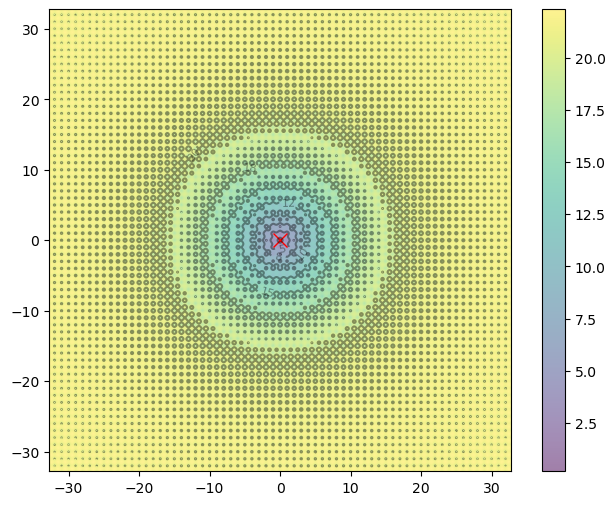

In [39]:
list_of_functions = ["Ackley","Rastgrin","Sphere","Rosenbrock","Booth","Easom"]

z,x,y,a,fx = create_benchmark("Ackley")

# Find the global minimum
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
x_max = x.ravel()[z.argmax()]
y_max = y.ravel()[z.argmax()]   
plt.figure(figsize=(8,6))
plt.imshow(z, extent=[a[0],a[1],a[0],a[1]], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=10, color="red")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()

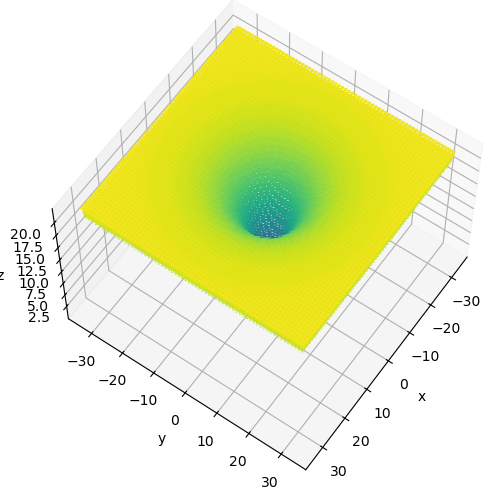

In [40]:
# plot the funciton in 3D
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.contour3D(x, y, z, 50, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(60, 35)
ax.plot([x_min], [y_min], [z.min()], marker='x', markersize=10, color="red")
plt.show()


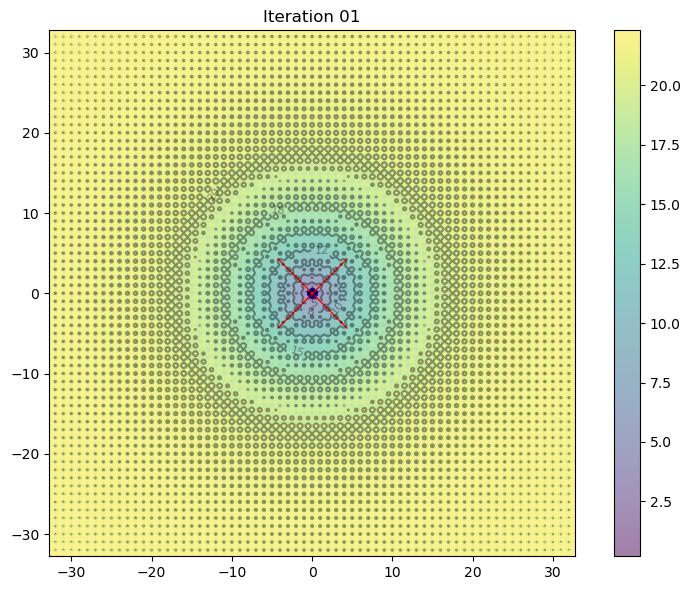

In [41]:
#PSO algorithm
# Hyper-parameter of the algorithm
c1 = 0.6
c2 = 0.6
w = 0.6

# Create particles
n_particles = 40
np.random.seed(100)
# Values of particles
# set the region of the particle to be the same as the region of the function
X = np.random.uniform(a[0], a[1], (2, n_particles))
# the velocity of the particle with random velocity sampled over a normal distribution with mean 0 and standard deviation 0.1
V = np.random.normal(0, 0.1, (2, n_particles))

gbest_list = []
# Initialize data
pbest = X
pbest_obj = fx(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()

# Set up base figure: The contour map
fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)

img = ax.imshow(z, extent=[a[0],a[1],a[0],a[1]], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=50, color="red")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
pbest_plot = ax.scatter(pbest[0], pbest[1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
p_arrow = ax.quiver(X[0], X[1], V[0], V[1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
gbest_plot = plt.scatter([gbest[0]], [gbest[1]], marker='*', s=100, color='black', alpha=0.4)
ax.set_xlim([a[0],a[1]])
ax.set_ylim([a[0],a[1]])


def apply_boundaries(X, V, lower_bound, upper_bound):
    # Apply boundaries to positions
    np.clip(X, lower_bound, upper_bound, out=X)

    # Reverse velocity if the particle hits the boundary
    for i in range(X.shape[1]):  # loop over each particle
        for j in range(X.shape[0]):  # loop over each dimension
            if X[j, i] == lower_bound or X[j, i] == upper_bound:
                V[j, i] *= -1

def update():
    "Function to do one iteration of particle swarm optimization"
    global V, X, pbest, pbest_obj, gbest, gbest_obj
    # store the gbest for each iteration
    # Update params
    r1, r2 = np.random.rand(2)
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    X = X + V
    obj = fx(X[0], X[1])
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    gbest = pbest[:, pbest_obj.argmin()]
    gbest_obj = pbest_obj.min()
    gbest_list.append(gbest_obj)

def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    # Update params
    update()
    apply_boundaries(X, V, a[0], a[1])
    # Set picture
    ax.set_title(title)
    pbest_plot.set_offsets(pbest.T)
    p_plot.set_offsets(X.T)
    p_arrow.set_offsets(X.T)
    p_arrow.set_UVC(V[0], V[1])
    gbest_plot.set_offsets(gbest.reshape(1,-1))
    return ax, pbest_plot, p_plot, p_arrow, gbest_plot


# Set iteration of update function and frame interval

iteration = list(range(1,30))
anim = FuncAnimation(fig, animate, frames=iteration, interval=100, blit=False, repeat=False)
anim
from IPython.display import HTML
HTML(anim.to_html5_video())


In [42]:
print("PSO found best solution at fx({})={}".format(gbest, gbest_obj))
print("Global optimal at fx({})={}".format([x_min,y_min], fx(x_min,y_min)))

PSO found best solution at fx([0.00042632 0.00036768])=0.0016007610436510333
Global optimal at fx([0.032800800800799834, 0.032800800800799834])=0.1876942137286548


In [43]:
# Bayesian Optimization algorithm
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Define the search space
space  = [Real(-10, 10, name='x'), Real(-10, 10, name='y')]

# Define the objective function to be minimized
@use_named_args(space)
def objective(**params):
    return fx(params['x'], params['y'])

# Perform Bayesian Optimization
result = gp_minimize(objective, space, n_calls=30,  random_state=0)

# Best found parameters and function value
print("Best parameters: {}".format(result.x))
print("Best function value: {}".format(result.fun))



Best parameters: [0.2139753266011546, 0.2068153300423763]
Best function value: 2.263337074809751


In [44]:
print(gbest_list)
print(result.func_vals)

[12.197212750591008, 4.56251209317913, 3.167485592238979, 3.167485592238979, 2.7827185770810736, 2.7827185770810736, 2.7827185770810736, 2.7375445534526293, 0.664232793602423, 0.664232793602423, 0.664232793602423, 0.664232793602423, 0.19785875737096248, 0.19785875737096248, 0.07741579621160355, 0.07700156123829416, 0.07700156123829416, 0.0022741422984147164, 0.0022741422984147164, 0.0022741422984147164, 0.0022741422984147164, 0.0022741422984147164, 0.0016069341730222675, 0.0016069341730222675, 0.0016069341730222675, 0.0016069341730222675, 0.0016007610436510333, 0.0016007610436510333, 0.0016007610436510333, 0.0016007610436510333, 0.0016007610436510333]
[13.43568985 15.73953649  9.82043577 15.43386705 11.85031119 13.78126176
 14.0990233  10.36664125 16.52987678 17.27916741  3.11040248 14.93832901
  6.55485971  3.29698791  2.63134436  3.38124026  4.60849633  2.53776583
  3.06584916  3.45573907 17.29329434 17.29329434  5.71572868  2.6615391
  2.49396042  2.42032846  2.51835971  2.26333707 

ValueError: x and y must have same first dimension, but have shapes (30,) and (31,)

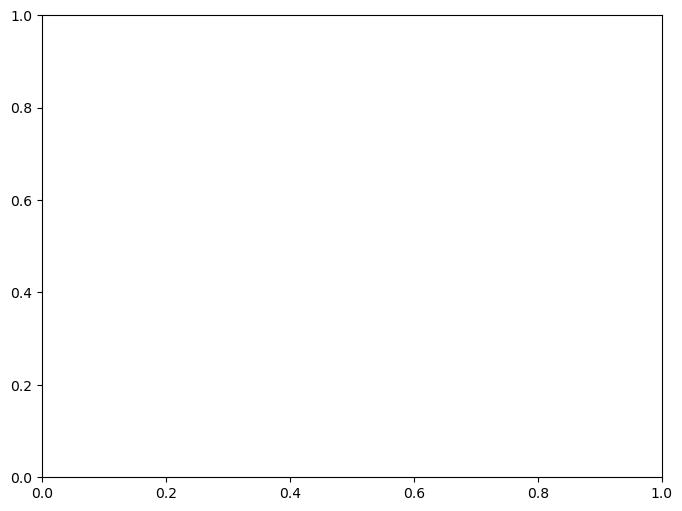

In [45]:
# plot the PSO and BO algorithm respect to the iteration and best function value
plt.figure(figsize=(8,6))
plt.plot(list(range(1,31)), gbest_list, label="PSO")
plt.plot(result.func_vals, label="BO")
plt.xlabel("Iteration")
plt.ylabel("Best function value")
plt.legend()

